In [ ]:
!pip install hstrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 2.5 MB/s eta 0:00:00


In [ ]:
from hstrader import HsTrader
from hstrader.models import Event, Tick, Order, CrtOrder, OrderType, SideType, Status, Position, Resolution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as

In [100]:
CLIENT_ID = "Your HsTrader client id"
SECRET = "Your HsTrader secret"


In [ ]:
# create an instance of HsTrader client
client = HsTrader(CLIENT_ID, SECRET)

In [ ]:
# HsTrader symbol
symbol = client.get_symbol("EURUSD")
# HsTrader market data
data = client.get_market_history(symbol, resolution=Resolution.D1,count_back = 1000)

In [ ]:

df = pd.DataFrame([historytick.dict() for historytick in data])
print(df)


                         time     open     high      low    close  \
0   2024-03-03 23:59:00+00:00  1.08368  1.08413  1.08368  1.08385   
1   2024-03-04 00:00:00+00:00  1.08385  1.08669  1.08385  1.08540   
2   2024-03-05 00:00:00+00:00  1.08540  1.08758  1.08397  1.08548   
3   2024-03-06 00:00:00+00:00  1.08548  1.09153  1.08413  1.08990   
4   2024-03-07 00:00:00+00:00  1.08990  1.09512  1.08673  1.09507   
..                        ...      ...      ...      ...      ...   
111 2024-07-11 00:00:00+00:00  1.08330  1.08996  1.08315  1.08741   
112 2024-07-12 00:00:00+00:00  1.08741  1.09113  1.08614  1.09039   
113 2024-07-13 00:00:00+00:00  1.09039  1.09039  1.08799  1.08855   
114 2024-07-15 00:00:00+00:00  1.08855  1.09223  1.08827  1.08974   
115 2024-07-16 00:00:00+00:00  1.08974  1.08987  1.08828  1.08984   

           volume  
0    2.356717e+03  
1    3.716924e+06  
2    6.193221e+06  
3    6.243879e+06  
4    6.268020e+06  
..            ...  
111  6.004146e+06  
112  5.5188

In [ ]:
df['time'] = pd.to_datetime(df['time']).dt.date
df.head()

time     open     high      low    close        volume
0  2024-03-03  1.08368  1.08413  1.08368  1.08385  2.356717e+03
1  2024-03-04  1.08385  1.08669  1.08385  1.08540  3.716924e+06
2  2024-03-05  1.08540  1.08758  1.08397  1.08548  6.193221e+06
3  2024-03-06  1.08548  1.09153  1.08413  1.08990  6.243879e+06
4  2024-03-07  1.08990  1.09512  1.08673  1.09507  6.268020e+06

In [ ]:
def get_stochastic_oscillator(df, period=14):
    for i in range(len(df)):
        low = df.iloc[i]['close']
        high = df.iloc[i]['close']
        if i >= period:
            n = 0
            while n < period:
                if df.iloc[i-n]['close'] >= high:
                    high = df.iloc[i-n]['close']
                elif df.iloc[i-n]['close'] < low:
                    low = df.iloc[i-n]['close']
                n += 1
            df.at[i, 'best_low'] = low
            df.at[i, 'best_high'] = high
            df.at[i, 'fast_k'] = 100*((df.iloc[i]['close']-df.iloc[i]['best_low'])/(df.iloc[i]['best_high']-df.iloc[i]['best_low']))

    df['fast_d'] = df['fast_k'].rolling(3).mean().round(2)
    df['slow_k'] = df['fast_d']
    df['slow_d'] = df['slow_k'].rolling(3).mean().round(2)

    return df

In [ ]:
df = get_stochastic_oscillator(df, period=14)

In [85]:

import plotly.express as px
import plotly.graph_objects as go

def chart_stochastic_oscillator_and_price(ticker, df):
    # Calculate moving averages
    df['ma50'] = df['close'].rolling(50).mean()
    df['ma200'] = df['close'].rolling(200).mean()

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        row_heights=[0.7, 0.3], vertical_spacing=0.02,
                        subplot_titles=(ticker, ''))

    fig.add_trace(go.Scatter(x=df['time'], y=df['close'], mode='lines', line=dict(color='black', width=1), showlegend=False, hoverinfo='skip'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['ma50'], mode='lines', line=dict(color='blue', width=1), showlegend=False, hoverinfo='skip'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['ma200'], mode='lines', line=dict(color='red', width=1), showlegend=False, hoverinfo='skip'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df['time'], y=df['fast_k'], mode='lines', line=dict(color='orange', width=1), showlegend=False, hoverinfo='skip'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['fast_d'], mode='lines', line=dict(color='grey', width=1), showlegend=False, hoverinfo='skip'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['slow_d'], mode='lines', line=dict(color='green', width=1), showlegend=False, hoverinfo='skip'), row=2, col=1)

    fig.add_shape(type='line', x0=df['time'].min(), x1=df['time'].max(), y0=80, y1=80, line=dict(color='blue', dash='dash'), row=2, col=1)
    fig.add_shape(type='line', x0=df['time'].min(), x1=df['time'].max(), y0=20, y1=20, line=dict(color='red', dash='dash'), row=2, col=1)

    fig.update_layout(
        height=800,
        width=1000,
        template='plotly_white',
        showlegend=False,
        hovermode=False,
        margin=dict(l=0, r=0, t=0, b=0),
        xaxis=dict(showgrid=False, zeroline=False, showline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showline=False, showticklabels=False),
    )

    fig.update_yaxes(title_text='Price [$]', row=1, col=1)
    fig.update_yaxes(title_text='S.O.', range=[0, 100], row=2, col=1)
    fig.update_xaxes(title_text='Time', row=2, col=1)

    fig.show()

In [86]:
chart_stochastic_oscillator(symbol.symbol, df)

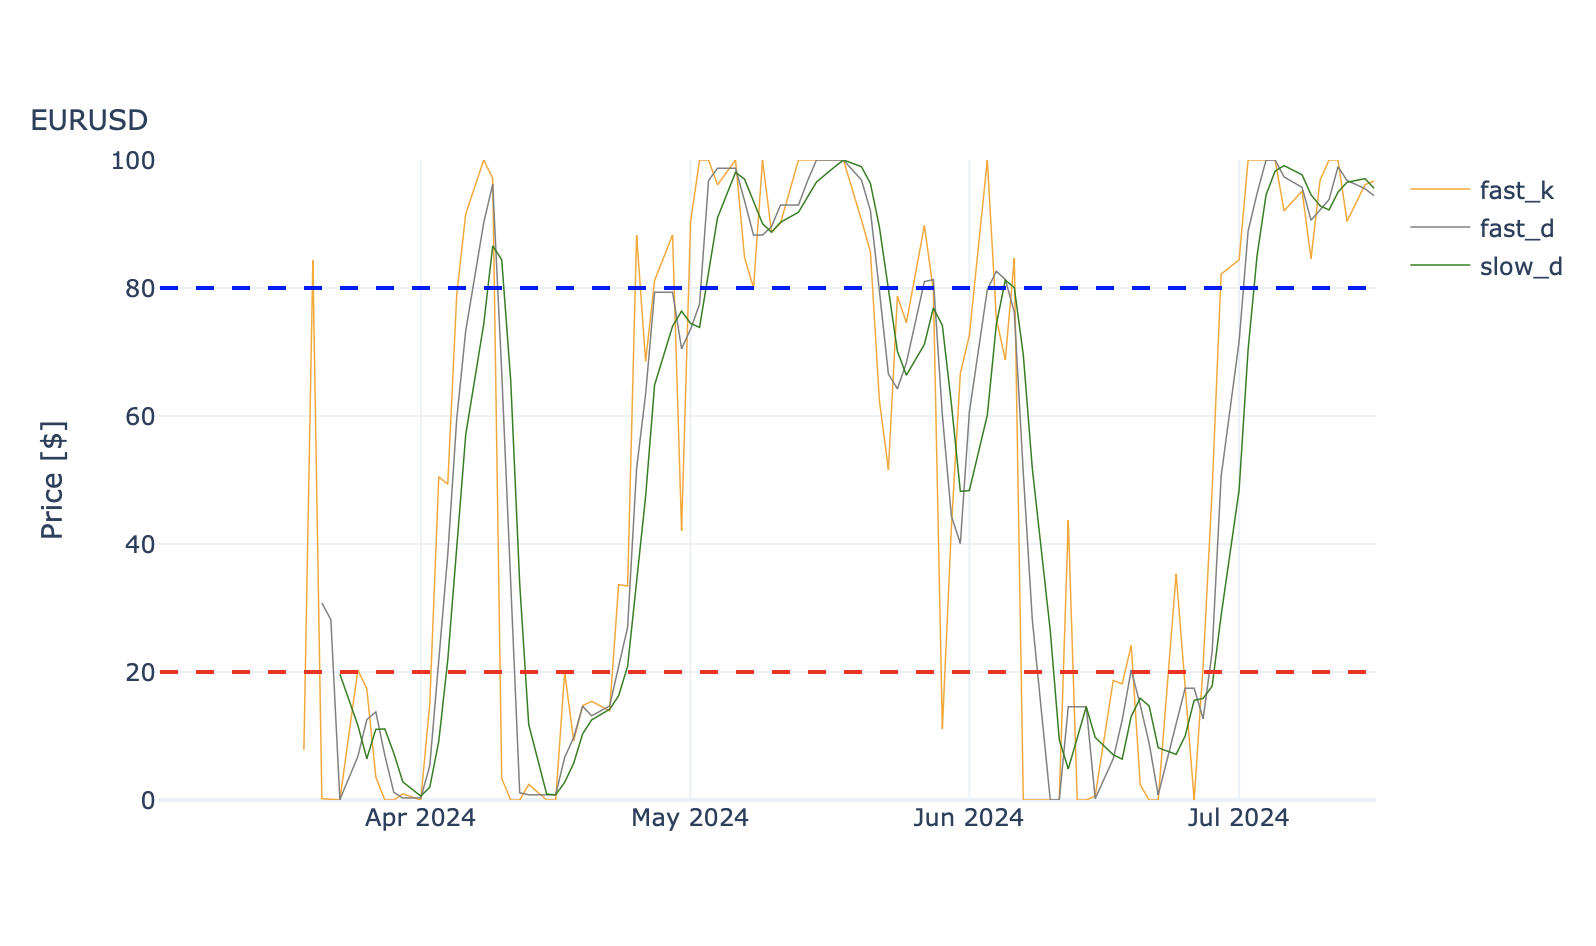

In [98]:
from IPython.display import Image, display
#static image just for review purposes
display(Image(filename='Visualization.png'))

In [91]:
from plotly.subplots import make_subplots

def chart_stochastic_oscillator_and_price(ticker, df):
    # Calculate moving averages
    df['ma50'] = df['close'].rolling(50).mean()
    df['ma200'] = df['close'].rolling(200).mean()

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                        row_heights=[0.7, 0.3], vertical_spacing=0.02,
                        subplot_titles=(ticker, ''))

    fig.add_trace(go.Scatter(x=df['time'], y=df['close'], mode='lines', name='Close', line=dict(color='black', width=1), hoverinfo='none'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['ma50'], mode='lines', name='MA50', line=dict(color='blue', width=1), hoverinfo='none'), row=1, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['ma200'], mode='lines', name='MA200', line=dict(color='red', width=1), hoverinfo='none'), row=1, col=1)

    fig.add_trace(go.Scatter(x=df['time'], y=df['fast_k'], mode='lines', name='fast_k', line=dict(color='orange', width=1), hoverinfo='none'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['fast_d'], mode='lines', name='fast_d', line=dict(color='grey', width=1), hoverinfo='none'), row=2, col=1)
    fig.add_trace(go.Scatter(x=df['time'], y=df['slow_d'], mode='lines', name='slow_d', line=dict(color='green', width=1), hoverinfo='none'), row=2, col=1)

    fig.add_shape(type='line', x0=df['time'].min(), x1=df['time'].max(), y0=80, y1=80, line=dict(color='blue', dash='dash'), row=2, col=1)
    fig.add_shape(type='line', x0=df['time'].min(), x1=df['time'].max(), y0=20, y1=20, line=dict(color='red', dash='dash'), row=2, col=1)

    fig.update_layout(
        height=800,
        width=1000,
        template='plotly_white',
        showlegend=True
    )

    fig.update_yaxes(title_text='Price [$]', row=1, col=1)
    fig.update_yaxes(title_text='S.O.', range=[0, 100], row=2, col=1)
    fig.update_xaxes(title_text='Time', row=2, col=1)
    fig.show()


In [92]:
chart_stochastic_oscillator_and_price(symbol.symbol, df)



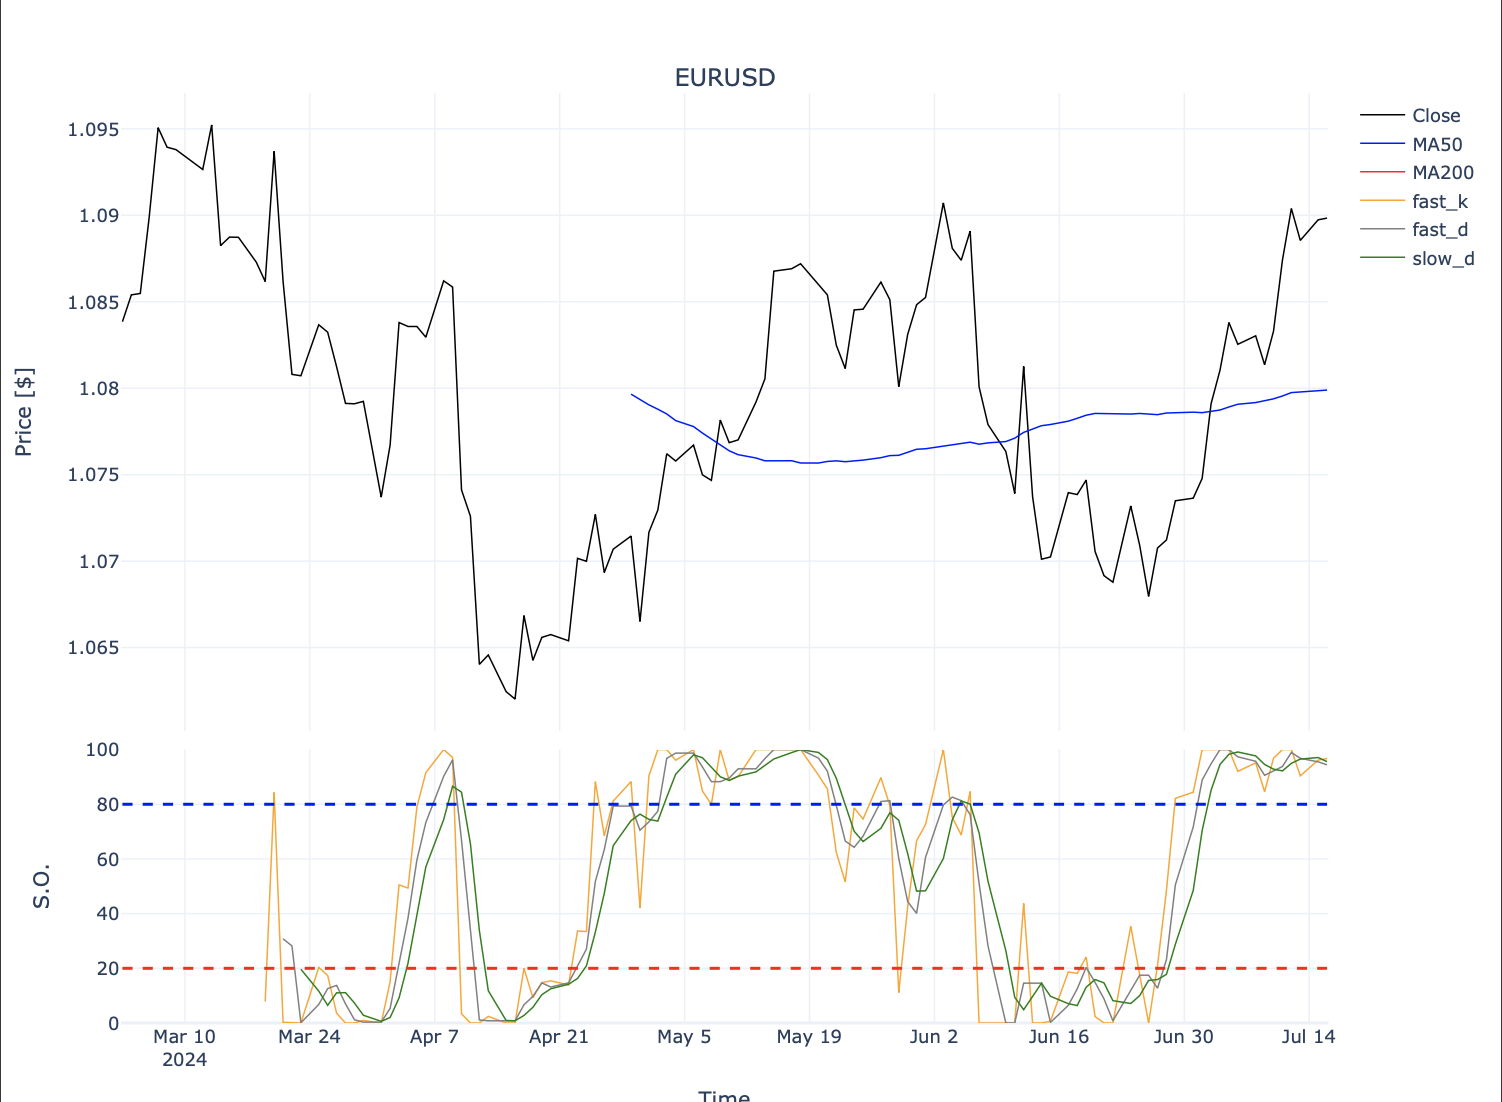

In [97]:
#static image just for review purposes

display(Image(filename='/img/chart_stochastic_oscillator_and_price..png'))

Plotting in real time

In [ ]:
from datetime import timedelta
import logging
import asyncio
import nest_asyncio

def calculate_stochastic_oscillator(df, k_period=14, d_period=3):
    """
    Calculate the Stochastic Oscillator for the given DataFrame.
    """
    low_min = df['low'].rolling(window=k_period).min()
    high_max = df['high'].rolling(window=k_period).max()
    
    df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
    df['%D'] = df['%K'].rolling(window=d_period).mean()
    
    return df

def Plot_Stochastic_Oscillator(df, fig):
    """
    Plot the Stochastic Oscillator on the given Plotly figure.
    """
    # Clear existing traces
    fig.data = []

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['open'],
        high=df['high'],
        low=df['low'],
        close=df['close'],
        name='Candlestick'
    ))

    # Add Stochastic Oscillator
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['%K'],
        mode='lines',
        line=dict(color='blue', width=1.5),
        name='%K',
        yaxis="y2"
    ))

    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['%D'],
        mode='lines',
        line=dict(color='red', width=1.5),
        name='%D',
        yaxis="y2"
    ))

    # Add horizontal lines at 20 and 80
    fig.add_hline(y=20, line_dash="dash", line_color="gray", opacity=0.7, yref="y2")
    fig.add_hline(y=80, line_dash="dash", line_color="gray", opacity=0.7, yref="y2")

    # Update layout
    fig.update_layout(
        title='Stochastic Oscillator with Candlestick Chart',
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,
        template='plotly_white',
        legend=dict(
            title='Indicators',
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        ),
        margin=dict(t=100),
        yaxis2=dict(
            title="Stochastic Oscillator",
            overlaying="y",
            side="right",
            range=[0, 100]
        )
    )

# Retrieve market data for any forex symbol by specifying its name in the get_symbol function
symbol = client.get_symbol('EURUSD')
data = client.get_market_history(symbol=symbol.id, resolution=Resolution.M1)

# Create a DataFrame from the retrieved data
df = pd.DataFrame([bar.model_dump() for bar in data])
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Calculate initial Stochastic Oscillator
df = calculate_stochastic_oscillator(df)

# Create initial plot
fig = go.Figure()
Plot_Stochastic_Oscillator(df, fig)
display(fig)

# Prepare data dictionary
CANDLE_INTERVAL = timedelta(minutes=1)
data = {
    'x': list(df.index),
    'open': list(df['open']),
    'high': list(df['high']),
    'low': list(df['low']),
    'close': list(df['close']),
    '%K': list(df['%K']),
    '%D': list(df['%D'])
}

@client.subscribe(Event.MARKET)
async def on_market(tick: Tick):
    global data, df

    try:
        if tick.symbol_id == symbol.id:
            tick_time = pd.to_datetime(tick.time)
            if not data['x']:
                data['x'].append(tick_time)
                data['open'].append(tick.bid)
                data['high'].append(tick.bid)
                data['low'].append(tick.bid)
                data['close'].append(tick.bid)
            elif tick_time >= data['x'][-1] + CANDLE_INTERVAL:
                data['x'].append(tick_time)
                data['open'].append(data['close'][-1])
                data['high'].append(tick.bid)
                data['low'].append(tick.bid)
                data['close'].append(tick.bid)
            else:
                data['low'][-1] = min(tick.bid, data['low'][-1])
                data['high'][-1] = max(tick.bid, data['high'][-1])
                data['close'][-1] = tick.bid

            df = pd.DataFrame({
                'time': data['x'],
                'open': data['open'],
                'high': data['high'],
                'low': data['low'],
                'close': data['close']
            }).set_index('time')

            # Calculate Stochastic Oscillator
            df = calculate_stochastic_oscillator(df)
            
            data['%K'] = list(df['%K'])
            data['%D'] = list(df['%D'])

    except Exception as e:
        logging.error(f"Error in on_market: {e}")
        await client.refresh_token()

async def update_plot():
    global data, df
    while True:
        await asyncio.sleep(1)
        clear_output(wait=True)
        new_fig = go.Figure()
        Plot_Stochastic_Oscillator(df, new_fig)
        display(new_fig)

nest_asyncio.apply()

# Ensure the event loop is running
loop = asyncio.get_event_loop()

# Run both the client and update_plot concurrently
loop.run_until_complete(
    asyncio.gather(
        client.start_async(), 
        update_plot()
    )
)